In [168]:
import pandas as pd
import numpy as np
import arviz as az
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.colors as mcolors
from scipy.special import expit, logit

import pymc as pm
import bambi as bmb
import pytensor.tensor as pt
import random

import collections.abc
collections.Iterable = collections.abc.Iterable
collections.Mapping = collections.abc.Mapping
collections.MutableSet = collections.abc.MutableSet
collections.MutableMapping = collections.abc.MutableMapping
from causalgraphicalmodels import CausalGraphicalModel
import daft

In [169]:
# versions

print('\n'.join(f'{m.__name__}=={m.__version__}' for m in globals().values() if getattr(m, '__version__', None)))

In [170]:
SEED = 20012808

In [171]:
# import the data prepared in ERF_get_data_prereg

real_data = pd.read_csv('...')
df2 = real_data.copy()

# limit to taxonomists
real_data = real_data.loc[real_data['taxonomist?'] == 'taxonomist']

# DAG


In [172]:
tax_dag_Concept = CausalGraphicalModel(
    nodes=["Species Concept", "Low income",  "Agree", 'Specialization', 'Treatment'], edges=[
        
        ("Species Concept", "Agree"),
        
        ("Low income", "Species Concept"),
        ("Specialization", "Species Concept"),       
        ('Treatment','Agree'),
        ('Specialization','Agree'),
        ('Low income','Agree')
    ]
)


tax_dag_Concept.draw()

Questions for case 2:

- What is the causal effect of treatment on 'agree'?
- What is the causal effect of species concept on 'agree'?
- Does treatment differ between low-income/high income? We expect this because different operationalizations are available differently depending on the budget.
- How does the influence of concepts compare to that of treatments?

In [173]:
def independencies(dag):
    all_independencies = dag.get_all_independence_relationships()
    for s in all_independencies:
        if all(
            t[0] != s[0] or t[1] != s[1] or not t[2].issubset(s[2])
            for t in all_independencies
            if t != s
        ):
            print(s)
independencies(tax_dag_Concept)

In [174]:
# check which variables to include

# function to check open backdoor paths and, hence, which variables to control for

def backdoor(dag, pred, outcome):
    all_adjustment_sets = dag.get_all_backdoor_adjustment_sets(pred, outcome)
    for s in all_adjustment_sets:
        if all(not t.issubset(s) for t in all_adjustment_sets if t != s):
            print(s)

backdoor(tax_dag_Concept,'Species Concept','Agree')

**In the paper, we report on model 6 below, given that it follows most directly from our DAG. This is the model:**

<u>*Likelihood:*</u>

Agree ~ Bernoulli(p)

*Linear model:*

logit(p<sub>i</sub>) = $\alpha$<sub>gen</sub> + $\alpha$1<sub>sc[i]</sub> + $\alpha$2<sub>tax[i]</sub> + $\alpha$3<sub>cont[i]</sub> + $\beta$_treat<sub>treat[i]</sub> + $\beta$_vartreat<sub>cont[i],treat[i]</sub> 


<u>*Fixed priors:*</u>
    
$\alpha$<sub>gen</sub> ~ Normal(0,1)

$\alpha$1_sigma ~ Uniform(0,5)

$\alpha$2_sigma ~ Uniform(0,5)

$\beta$_vartreat_sigma ~ Uniform(0,5)

$\beta$_treat<sub>treat</sub> ~ Normal(0,1)  
    
$\alpha$3<sub>cont</sub> ~ Normal(0,1)  
  


<u>*Adaptive priors:*</u>

$\alpha$1<sub>sc</sub> ~ Normal(0,$\alpha$1_sigma)

$\alpha$2<sub>tax</sub> ~ Normal(0,$\alpha$2_sigma) 

$\beta$_vartreat<sub>cont,treat</sub> ~ Normal(0,$\beta$_vartreat_sigma) 





# Indices and data

## Real data

In [175]:
df = real_data[['c1_agree','condition_c1','specialization','low_income','species_concepts', 'main_data']].copy()
df.columns = ['agree','t','tax','cont','sc','main_data']
df = df.dropna()
df = df[~df.apply(lambda row: row.astype(str).str.contains('No response', case=False).any(), axis=1)]
df = df.astype('category')
df = df.loc[df.main_data == 1]
df.head()

In [176]:
pd.crosstab(df.t,df.agree)

## coordinates for the models

In [177]:
#  Index of positions
t_idx = df.t.cat.codes.values
sc_idx = df.sc.cat.codes.values
agree_idx = df.agree.cat.codes.values
tax_idx = df.tax.cat.codes.values
cont_idx = df.cont.cat.codes.values



# The 9 position names
t_codes = df.t.cat.categories.values
sc_codes = df.sc.cat.categories.values
tax_codes = df.tax.cat.categories.values
cont_codes = df.cont.cat.categories.values



coords = {'t_n': t_codes,  'sc_n':sc_codes, 'tax_n':tax_codes, 'c_n':cont_codes, 'agree_codes':agree_idx}

# Model 1: Treatment --> Agree

In [178]:
with pm.Model(coords = coords) as m1:
    
    # Data
    T = pm.MutableData('T', df.t.cat.codes.values)
    
    # priors
    a_t = pm.Normal('a_t',0,1,dims = 't_n')
    a = pm.Normal('a',0,1)
    
    # linear model
    p = pm.math.invlogit(a + a_t[T])
    
    agree = pm.Bernoulli('agree',p=p, observed = df.agree.cat.codes.values)
    
    tracem1 = pm.sample(10000,idata_kwargs={"log_likelihood": True})

In [179]:
az.summary(tracem1)

# Model 2: Add species concept

In [180]:
with pm.Model(coords = coords) as m2:
    
    # data
    S = pm.MutableData('S', df.sc.cat.codes.values)
    T = pm.MutableData('T', df.t.cat.codes.values)
    
    # priors
    a_sc = pm.Normal('a_sc',0,1,dims = 'sc_n')
    t = pm.Normal('t',0,1,dims = 't_n')
    a = pm.Normal('a',0,1)
    
    # linear model
    p = pm.math.invlogit(a + a_sc[S] + t[T])
    
    agree = pm.Bernoulli('agree',p=p, observed = df.agree.cat.codes.values)
    
    tracem2 = pm.sample(10000,idata_kwargs={"log_likelihood": True})

In [181]:
az.summary(tracem2)

# Model 3: Add controls for tax and cont

This is necessary to get the causal effect of species concepts

In [182]:
with pm.Model(coords=coords) as m3:
    
    # data
    S = pm.MutableData('S', df.sc.cat.codes.values)
    T = pm.MutableData('T', df.t.cat.codes.values)
    TA = pm.MutableData('TA', df.tax.cat.codes.values)
    C = pm.MutableData('C', df.cont.cat.codes.values)
    
    # priors
    a = pm.Normal('a',0,1)
    a_sc = pm.Normal('a_sc',0,1,dims = 'sc_n')
    b1 = pm.Normal('b1',0,1,dims = 't_n')
    b2 = pm.Normal('b2',0,1,dims = 'tax_n')
    b3 = pm.Normal('b3',0,1)
    
    # linear model
    p = a + a_sc[S] + b1[T] + b2[TA] + b3*C
    
    agree = pm.Bernoulli('agree',logit_p=p, observed = df.agree.cat.codes.values)
    pr3 = pm.sample_prior_predictive()               

In [183]:
with m3:
    tracem3 = pm.sample(idata_kwargs={"log_likelihood": True})

In [184]:
az.summary(tracem3).head()

# multilevel models

We see no reason why treatment would vary by anything but income, or perhaps taxon, so that's all we model.

## Model 4: Treatment  + sc

In [185]:
with pm.Model(coords=coords) as m4:
    
    # data
    S = pm.MutableData('S', df.sc.cat.codes.values)
    T = pm.MutableData('T', df.t.cat.codes.values)
    
    # fixed priors
    a_gen = pm.Normal('a_gen',0,1)
    a1_sigma = pm.Uniform('a1_sigma',0,5) # hyperprior for sc
    b_t = pm.Normal('b_t',0,2, dims = 't_n')
    
    # adaptive priors (non centered)
    z1 = pm.Normal('z1',0,1, dims = 'sc_n')
    a1 = pm.Deterministic("a1",z1*a1_sigma)
    
    # linear model
    p = (a_gen + a1[S]  + b_t[T])
    
    agree = pm.Bernoulli('agree',logit_p=p, observed = df.agree.cat.codes.values)
    
    pr4 = pm.sample_prior_predictive()

In [186]:
with m4: 
    tracem4 = pm.sample(10000, tune = 3000,idata_kwargs={"log_likelihood": True}, target_accept = 0.95)


In [187]:
az.summary(tracem4).head()

## Model 5: add continent and varying effects for continent

In [188]:
with pm.Model(coords=coords) as m5:
    
    # data
    S = pm.MutableData('S', df.sc.cat.codes.values)
    T = pm.MutableData('T', df.t.cat.codes.values)
    C = pm.MutableData('C',df.cont.cat.codes.values)
    
    # fixed priors
    a_gen = pm.Normal('a_gen',0,1)
    a1_sigma = pm.Uniform('a1_sigma',0,5)
    b_t = pm.Normal('b_t',0,2, dims = 't_n')
    b_ct_sigma = pm.Uniform('b_ct_sigma',0,5)
    a_cont = pm.Normal('a_cont',0,1)

    
    # adaptive priors (non centered)
    z1 = pm.Normal('z1',0,1, dims = 'sc_n')
    z3 = pm.Normal('z3',0,1, dims = ('t_n'))
    a1 = pm.Deterministic("a1",z1*a1_sigma)
    b_ct = pm.Deterministic("b_ct", z3*b_ct_sigma)
    
    # linear model
    p = (a_gen + a1[S]  + b_t[T] + a_cont*C + b_ct[T]*C )
    
    agree = pm.Bernoulli('agree',logit_p=p, observed = df.agree.cat.codes.values)
    
    pr5 = pm.sample_prior_predictive()

In [189]:
#check priors

fig, axs = plt.subplots(2,3, figsize = (20,6))

for ax, para in zip(axs.flat, ['a_gen', 'a1','a1_sigma','b_ct','b_ct_sigma','b_t']):
    if len(pr5.prior[para].shape) == 3:
        az.plot_posterior(pr5.prior[para][:,:,0], ax=ax)
    elif len(pr5.prior[para].shape) == 2:
        az.plot_posterior(pr5.prior[para],ax=ax)
    else:
        az.plot_posterior(pr5.prior[para][:,:,1,0],ax=ax)
plt.suptitle('priors', fontsize = 20) 

plt.show()
fig.tight_layout()

In [190]:
with m5: 
    tracem5 = pm.sample(10000, tune = 3000, target_accept = 0.97,idata_kwargs={"log_likelihood": True})

In [191]:
az.summary(tracem5).head()

## Model 6: Add taxon

<u>*Likelihood:*</u>

Agree ~ Bernoulli(p)

*Linear model:*

logit(p<sub>i</sub>) = $\alpha$<sub>gen</sub> + $\alpha$1<sub>sc[i]</sub> + $\alpha$2<sub>tax[i]</sub> + $\alpha$3<sub>cont[i]</sub> + $\beta$_treat<sub>treat[i]</sub> + $\beta$_vartreat<sub>cont[i],treat[i]</sub> 


<u>*Fixed priors:*</u>
    
$\alpha$<sub>gen</sub> ~ Normal(0,1)

$\alpha$1_sigma ~ Uniform(0,5)

$\alpha$2_sigma ~ Uniform(0,5)

$\beta$_vartreat_sigma ~ Uniform(0,5)

$\beta$_treat<sub>treat</sub> ~ Normal(0,1)  
    
$\alpha$3<sub>cont</sub> ~ Normal(0,1)  
  


<u>*Adaptive priors:*</u>

$\alpha$1<sub>sc</sub> ~ Normal(0,$\alpha$1_sigma)

$\alpha$2<sub>tax</sub> ~ Normal(0,$\alpha$2_sigma) 

$\beta$_vartreat<sub>cont,treat</sub> ~ Normal(0,$\beta$_vartreat_sigma) 


In [192]:
with pm.Model(coords=coords) as m6:
    
    # data
    S = pm.MutableData('S', df.sc.cat.codes.values)
    T = pm.MutableData('T', df.t.cat.codes.values)
    C = pm.MutableData('C',df.cont.cat.codes.values)
    TA = pm.MutableData('TA',df.tax.cat.codes.values)
    
    # fixed priors
    a_gen = pm.Normal('a_gen',0,1)
    a1_sigma = pm.Uniform('a1_sigma',0,5)
    b_treat = pm.Normal('b_treat',0,2, dims = 't_n')
    b_vartreat_sigma = pm.Uniform('b_vartreat_sigma',0,5)
    a3 = pm.Normal('a3',0,1, dims = 'c_n' )
    a2_sigma = pm.Uniform('a2_sigma',0,5)

    
    # adaptive priors (non centered)
    z1 = pm.Normal('z1',0,1, dims = 'sc_n')
    z3 = pm.Normal('z3',0,1, dims = ('c_n','t_n'))
    a1 = pm.Deterministic("a1",z1*a1_sigma, dims = 'sc_n')
    b_vartreat = pm.Deterministic("b_vartreat", z3*b_vartreat_sigma, dims = ('c_n','t_n'))
    z2 = pm.Normal('z2',0,1, dims = 'tax_n')
    a2 = pm.Deterministic("a2",z2*a2_sigma, dims = 'tax_n')
    
    # linear model
    p = (a_gen + a1[S] + a2[TA] + a3[C] + b_treat[T] + b_vartreat[C,T])
    
    agree = pm.Bernoulli('agree',logit_p=p, observed = df.agree.cat.codes.values)
    
    pr6 = pm.sample_prior_predictive()

In [193]:
with m6: 
    tracem6 = pm.sample(10000, tune = 3000, target_accept = 0.97,idata_kwargs={"log_likelihood": True})

In [194]:
az.summary(tracem6).head()

## Model 7: Vary treatment by taxon

In [195]:
with pm.Model(coords=coords) as m7:
    
    # data
    S = pm.MutableData('S', df.sc.cat.codes.values)
    T = pm.MutableData('T', df.t.cat.codes.values)
    C = pm.MutableData('C',df.cont.cat.codes.values)
    TA = pm.MutableData('TA',df.tax.cat.codes.values)
    
    # fixed priors
    a_gen = pm.Normal('a_gen',0,1)
    a1_sigma = pm.Uniform('a1_sigma',0,5)
    b_t = pm.Normal('b_t',0,2, dims = 't_n')
    b_ct_sigma = pm.Uniform('b_ct_sigma',0,5)
    b_tt_sigma = pm.Uniform('b_tt_sigma',0,5)
    a_cont = pm.Normal('a_cont',0,1)
    a_tax_sigma = pm.Uniform('a_tax_sigma',0,5)

    
    # adaptive priors (non centered)
    z1 = pm.Normal('z1',0,1, dims = 'sc_n')
    z3 = pm.Normal('z3',0,1, dims = ('t_n'))
    a1 = pm.Deterministic("a1",z1*a1_sigma, dims = 'sc_n')
    b_ct = pm.Deterministic("b_ct", z3*b_ct_sigma, dims = 't_n')
    z2 = pm.Normal('z2',0,1, dims = 'tax_n')
    a_tax = pm.Deterministic("a_tax",z2*a_tax_sigma, dims = 'tax_n')
    z4 = pm.Normal('z4',0,1, dims = ('tax_n','t_n'))
    b_tt = pm.Deterministic('b_tt',z4*b_ct_sigma, dims = ('tax_n','t_n'))
    
    p = (a_gen + a1[S]  + b_t[T] + a_cont*C + b_ct[T]*C + a_tax[TA] + b_tt[TA, T])
    
    agree = pm.Bernoulli('agree',logit_p=p, observed = df.agree.cat.codes.values)
    
    pr7 = pm.sample_prior_predictive()

In [196]:
with m7: 
    tracem7 = pm.sample(10000, tune = 3000, target_accept = 0.99,idata_kwargs={"log_likelihood": True})

In [197]:
az.summary(tracem7).head()

# Compare models

Note that this just checks the in and out of sample fit of the models -- no causal conclusions can be drawn from this.

In [198]:
models = {'only t':tracem1, 't+sc':tracem2,'t+sc+tax+c':tracem3,'ml t+sc':tracem4, 'ml t+sc+c':tracem5,'ml t+sc+c+tax':tracem6,'ml t+sc+c+tax_ve':tracem7}

a = az.compare(models)
a

In [199]:
az.plot_compare(a, insample_dev = True)

# Results and interpretation

## General

In [241]:
az.summary(tracem6, var_names = ['a_gen','a1','b_treat','b_vartreat']).to_clipboard()

In [220]:
# check observations

pd.crosstab(df.t, df.agree, normalize = 'index')

agree,no,yes
t,,
Abundant,0.803279,0.196721
Neutral,0.832000,0.168000
Threatened,0.779528,0.220472


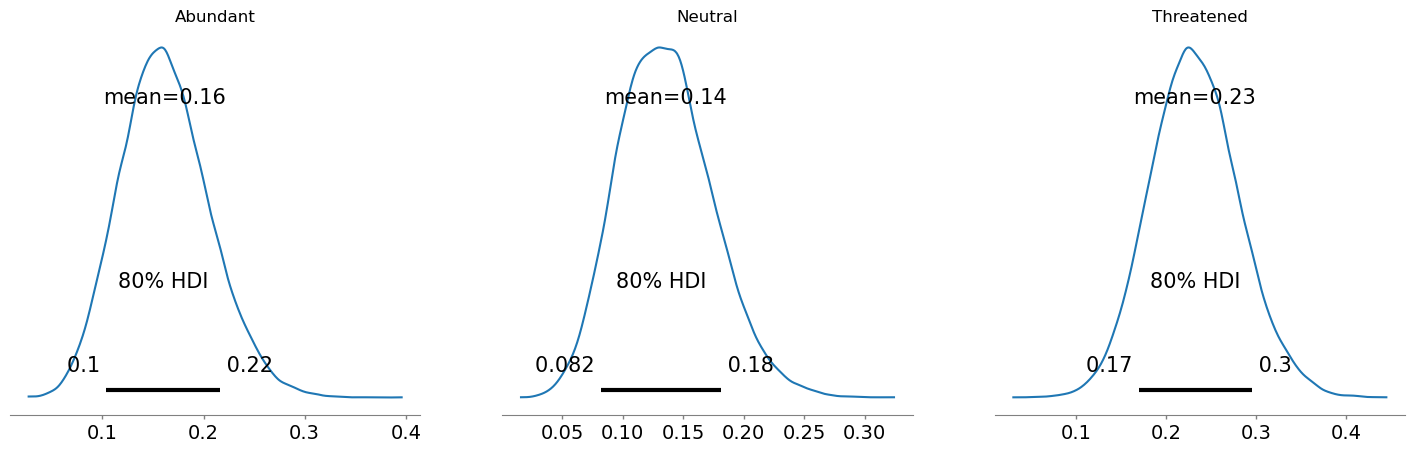

In [221]:
# marginal at the mean for the treatments

fig, axs = plt.subplots(ncols = 3, figsize = (18,5))

for ax,i in zip(axs.flat, ['Abundant', 'Neutral','Threatened']):
    a = (tracem6.posterior['a_gen'] + 
        tracem6.posterior['a1'].mean(dim = 'sc_n')+
        tracem6.posterior['b_treat'].loc[:,:,i] +
        (tracem6.posterior['a3'].mean(dim = 'c_n')) +
       tracem6.posterior['b_vartreat'].loc[:,:,:,i].mean(dim = 'c_n')+
        tracem6.posterior['a2'].mean(dim = 'tax_n'))
    az.plot_posterior(expit(a), hdi_prob = 0.8,ax=ax)
    ax.set_title(i)

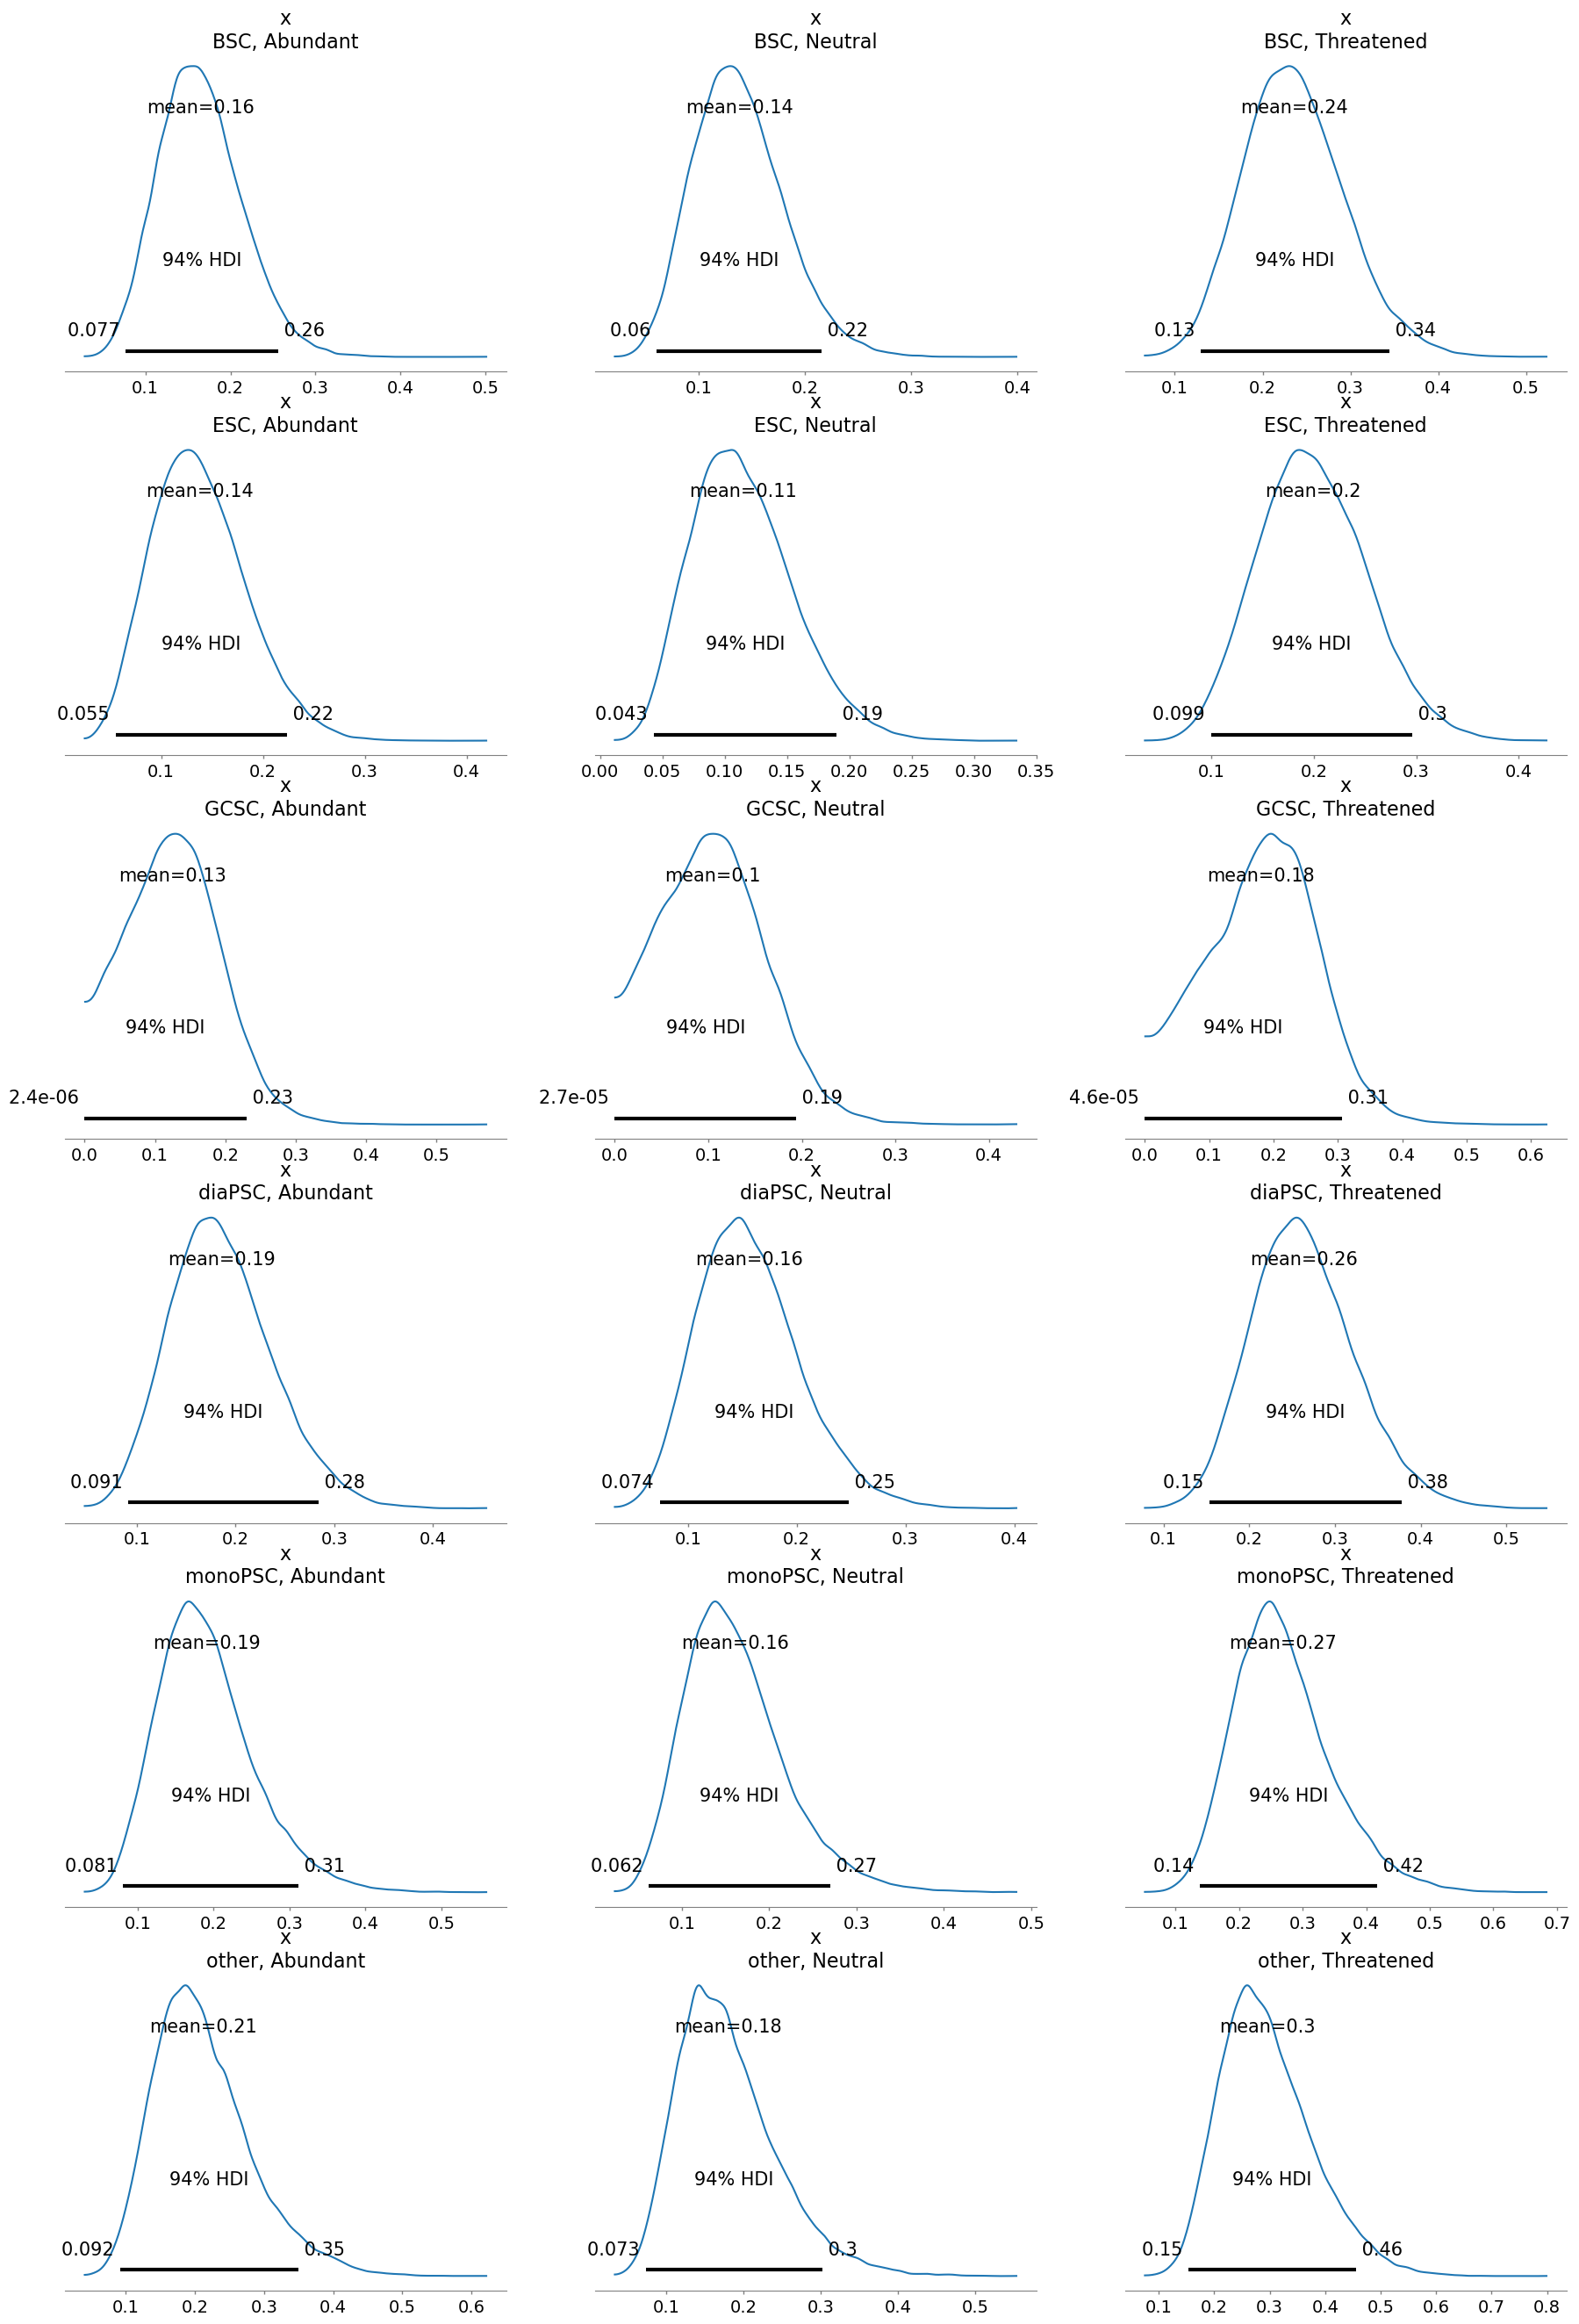

In [222]:
# marginal at the mean for sc x treatment

a = (tracem6.posterior['a_gen'] + 
        tracem6.posterior['a1']+
        tracem6.posterior['b_treat'] +
        (tracem6.posterior['a3'].mean(dim = 'c_n')) +
       tracem6.posterior['b_vartreat'].mean(dim = 'c_n')+
        tracem6.posterior['a2'].mean(dim = 'tax_n'))
az.plot_posterior(expit(a))
plt.show()

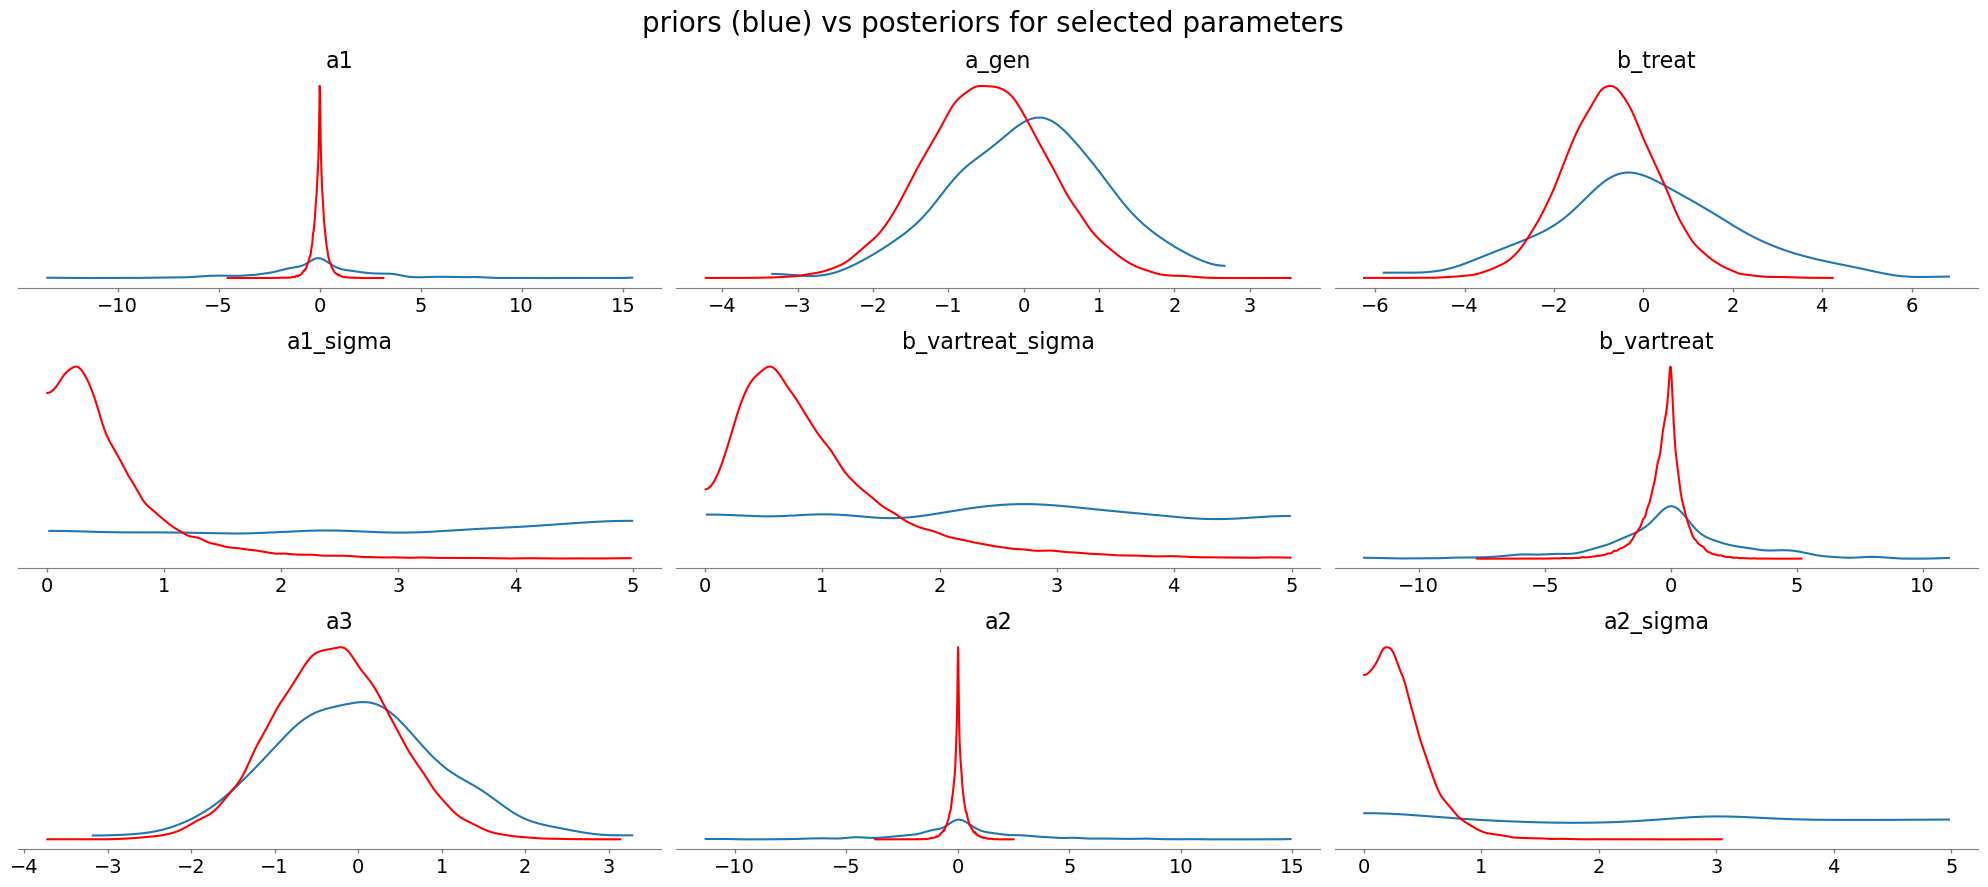

In [223]:
#selected priors vs posteriors
fig, axs = plt.subplots(3,3, figsize = (20,9))

for ax, para in zip(axs.flat, ['a1','a_gen','b_treat','a1_sigma','b_vartreat_sigma','b_vartreat','a3', 'a2', 'a2_sigma']):
    if len(pr6.prior[para].shape) == 3:
        az.plot_posterior(pr6.prior[para][:,:,0], hdi_prob = 'hide',point_estimate = None, ax=ax)
        az.plot_posterior(tracem6.posterior[para][:,:,0], point_estimate = None,hdi_prob = 'hide', color = 'red', ax=ax)
    elif len(pr6.prior[para].shape) == 2:
        az.plot_posterior(pr6.prior[para], hdi_prob = 'hide',point_estimate = None,ax=ax)
        az.plot_posterior(tracem6.posterior[para],hdi_prob ='hide', point_estimate = None,color = 'red',ax=ax)
    else:
        az.plot_posterior(pr6.prior[para][:,:,1,0], hdi_prob = 'hide',point_estimate = None,ax=ax)
        az.plot_posterior(tracem6.posterior[para][:,:,1,0], hdi_prob = 'hide',point_estimate = None,color = 'red',ax=ax)
        
plt.suptitle('priors (blue) vs posteriors for selected parameters', fontsize = 20) 

fig.tight_layout()

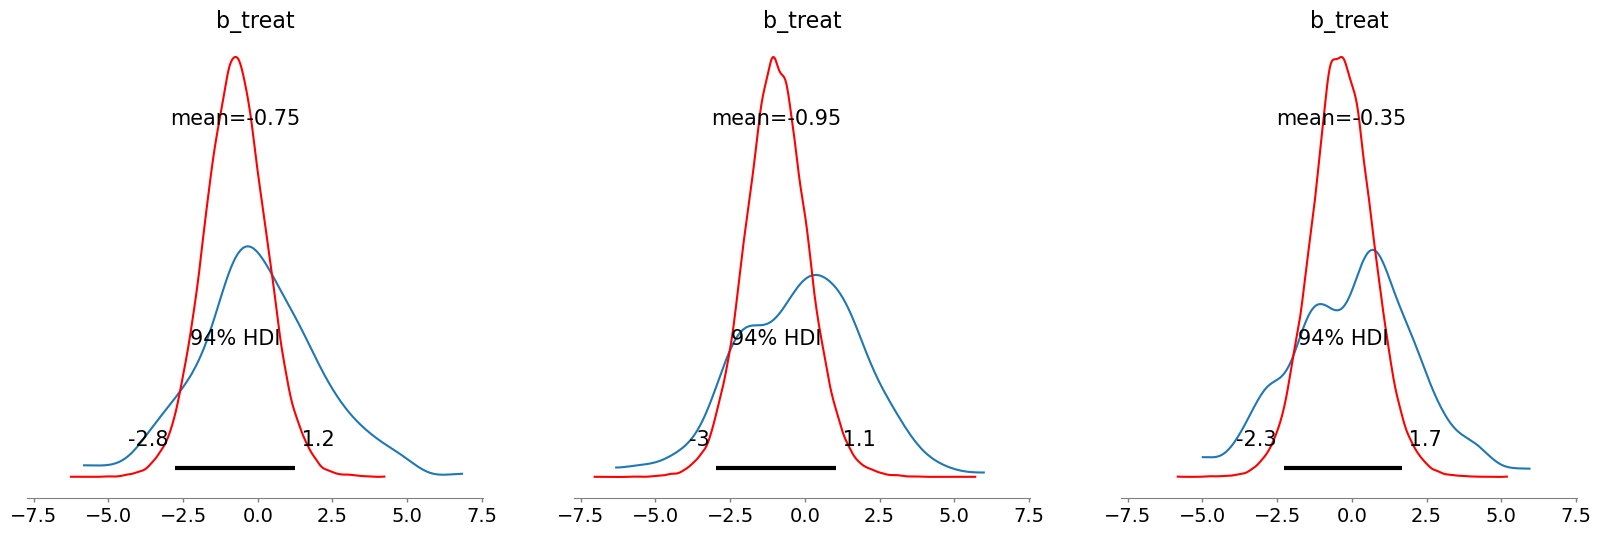

In [224]:
# prior vs posterior for the treatments


fig, axs = plt.subplots(1,3, figsize = (20,6), sharex = True)

for ax, i in zip(axs.flat, range(3)):
    az.plot_posterior(pr6.prior['b_treat'][:,:,i], point_estimate = None, hdi_prob = 'hide',ax=ax)
    az.plot_posterior(tracem6.posterior['b_treat'][:,:,i], color = 'red',ax=ax)

As it happens, the coefficients for tax and cont do give an idea of their direct influence according to our dag (i.e. without their influence through species concept)

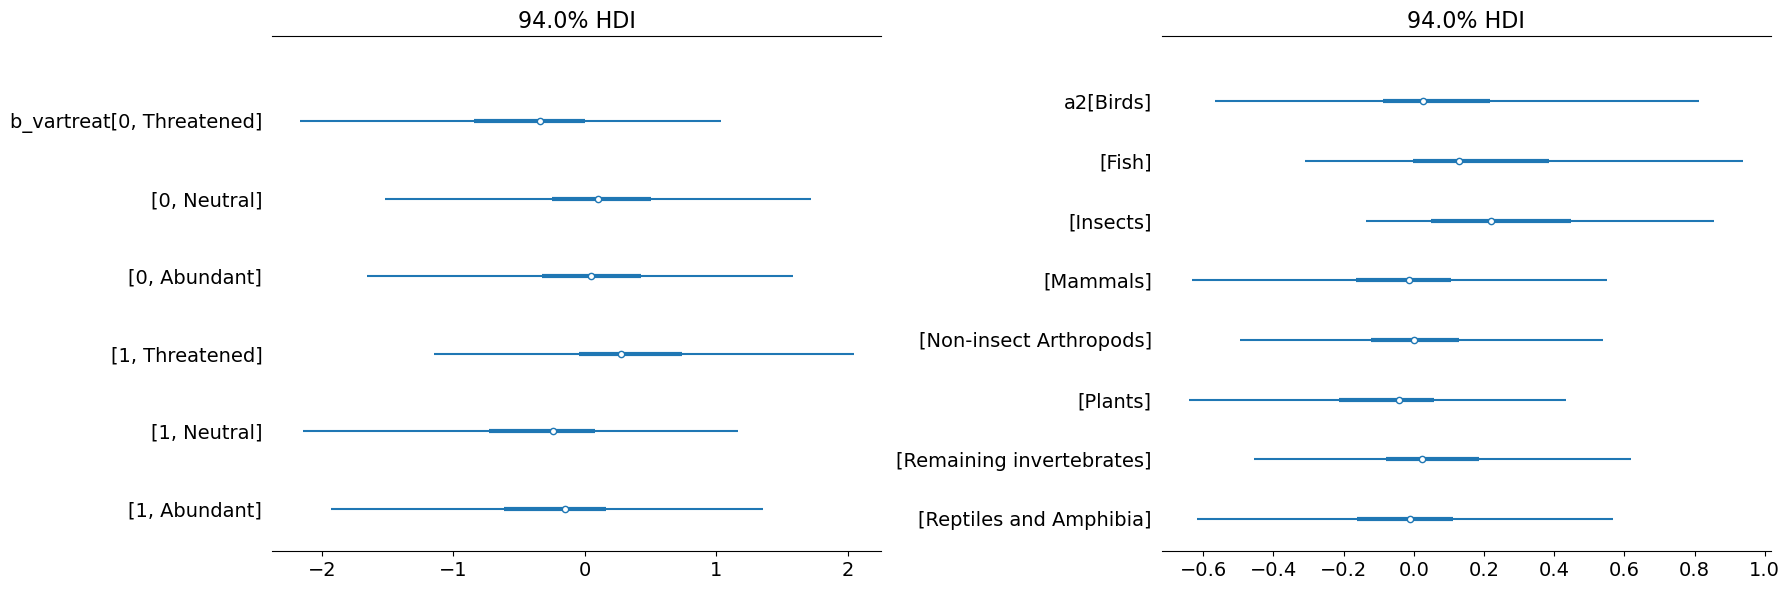

In [225]:
fig, ax = plt.subplots(ncols = 2, figsize = (18,6))

az.plot_forest(tracem6, var_names = ['b_vartreat'], coords ={'t_n':['Threatened','Neutral','Abundant']}, combined = True, ax = ax[0])
az.plot_forest(tracem6, 
               var_names = ['a2'], 
               coords = {'tax_n': [ 'Birds', 'Fish', 'Insects', 'Mammals',
                                                                   'Non-insect Arthropods','Plants', 
                                                                   'Remaining invertebrates','Reptiles and Amphibia']}, 
               combined = True, ax = ax[1])
fig.tight_layout()

## Causal effect of treatment

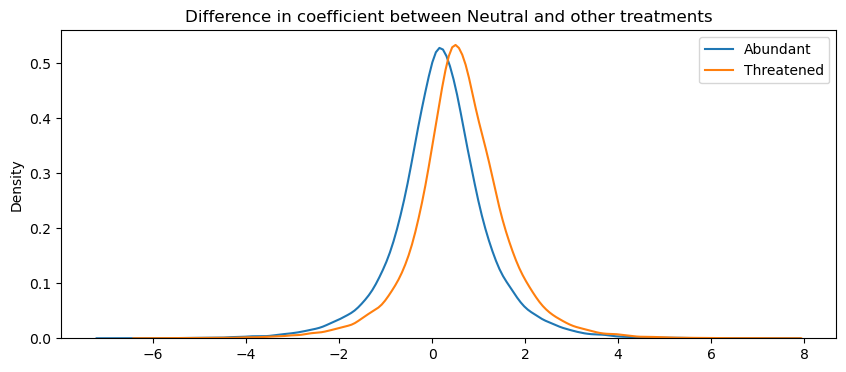

In [226]:
# plot difference in coefficients

fig, ax = plt.subplots(figsize = (10,4))
NEUT_result = tracem6.posterior['b_treat'].loc[:,:,'Neutral']

difs = []
for i in ['Abundant','Threatened']:
    sns.kdeplot(np.ravel(tracem6.posterior['b_treat'].loc[:,:,i] - NEUT_result),  ax=ax)
    
ax.set_title('Difference in coefficient between Neutral and other treatments')
ax.legend(['Abundant','Threatened'])
plt.show()

In [228]:
# create new data for T
new_t_data = {}

for i in range(3):
    new_t_data[f't{i}'] = np.repeat(i, len(df))

ppc = {}

with m6:
    for i in range(3):
        pm.set_data(
            {
                "T":new_t_data[f't{i}'],
                "C": np.repeat(1,len(df))
            }
        )
        ppct = pm.sample_posterior_predictive(tracem6, progressbar = False)
        ppc[f't{i}'] = ppct

Sampling: [agree]
Sampling: [agree]
Sampling: [agree]


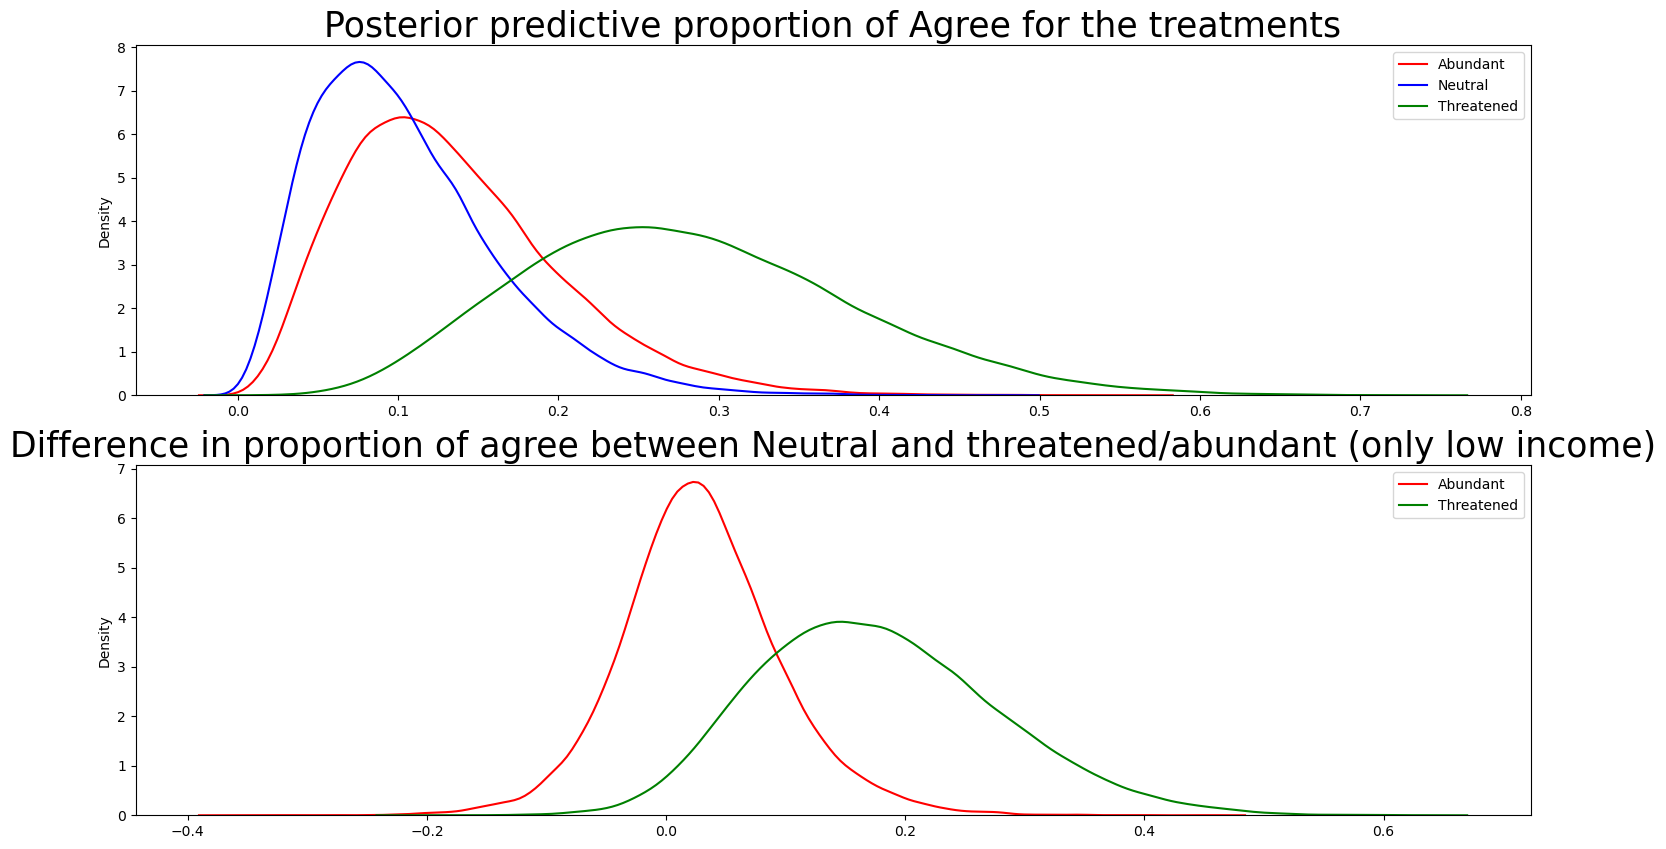

In [229]:
Neutral = az.extract(ppc[f't{1}'].posterior_predictive['agree'])['agree'].values.sum(axis = 0) / len(df)

colors = ['red','blue','green','orange']

fig, ax = plt.subplots(nrows = 2, figsize = (18,10))

for i in range(3):
    a = az.extract(ppc[f't{i}'].posterior_predictive['agree'])['agree'].values.sum(axis = 0) / len(df)

    sns.kdeplot(np.array(a), color = colors[i],ax=ax[0] )
    
ax[0].set_title('Posterior predictive proportion of Agree for the treatments', fontsize = 25)
ax[0].legend(['Abundant', 'Neutral','Threatened'])

for i in [0,2]:
    a = az.extract(ppc[f't{i}'].posterior_predictive['agree'])['agree'].values.sum(axis = 0) / len(df)
    sns.kdeplot(np.array(a) - Neutral, color = colors[i],ax=ax[1] )

    
ax[1].set_title('Difference in proportion of agree between Neutral and threatened/abundant (only low income)', fontsize = 25)
ax[1].legend(['Abundant', 'Threatened'])

plt.show()

## Causal effect of SC on 'Agree'

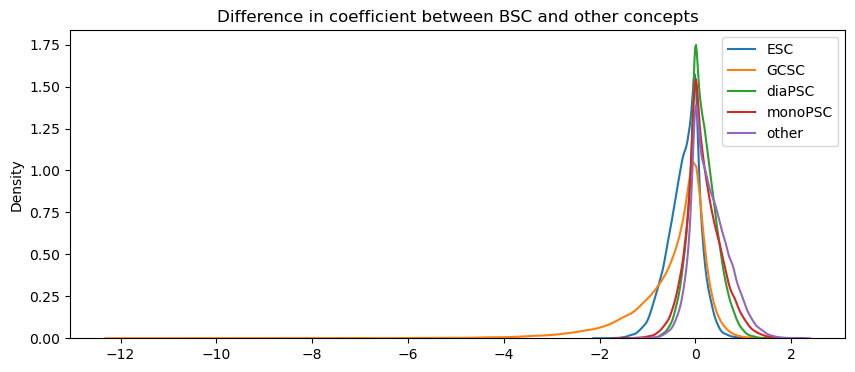

In [230]:
# plot difference in coefficients

fig, ax = plt.subplots(figsize = (10,4))
BSC_result = tracem6.posterior['a1'].loc[:,:,'BSC']

difs = []
for i in tracem6.posterior['sc_n'].values[1:]:
    sns.kdeplot(np.ravel(tracem6.posterior['a1'].loc[:,:,i] - BSC_result),  ax=ax)
    
ax.set_title('Difference in coefficient between BSC and other concepts')
ax.legend(list(tracem6.posterior['sc_n'].values[1:]))
plt.show()

Sampling: [agree]
Sampling: [agree]
Sampling: [agree]
Sampling: [agree]
Sampling: [agree]
Sampling: [agree]


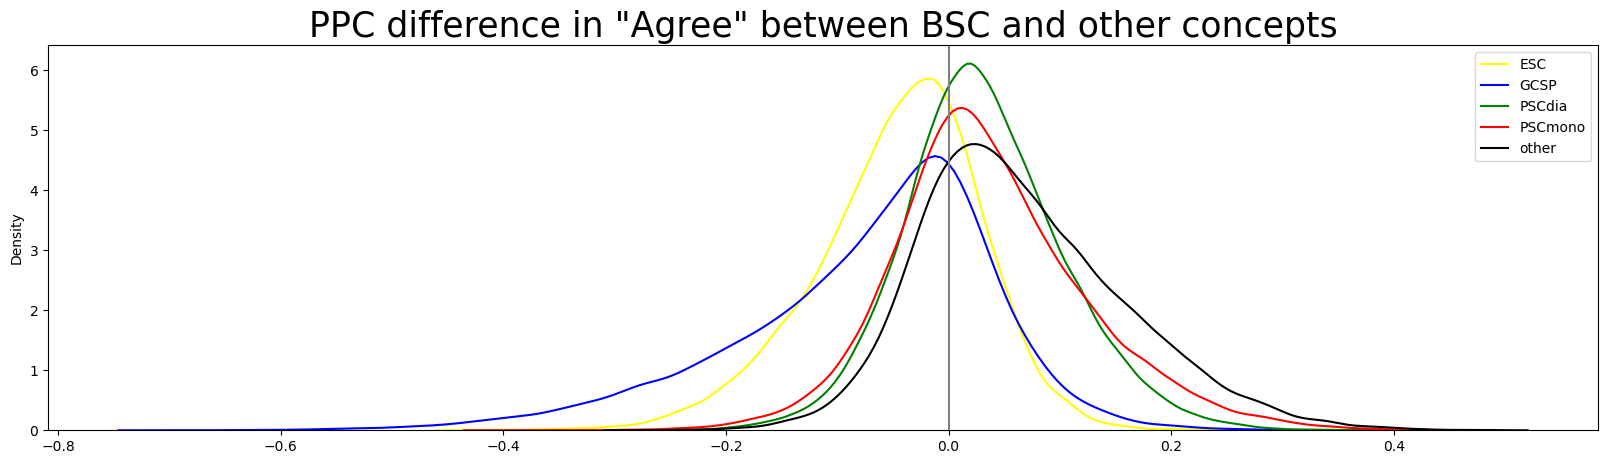

In [231]:
# posterior predictive: resample with full sample subscribing to each of the concepts, and compare resulting agree

# create new data for SC

new_sc_data = {f'sc{i}': np.repeat(i, len(df)) for i in range(6)}

# sample 6x ppc setting full sample for one concept in turn

ppcs = {}
with m6:
    for i in list(range((6))):
        pm.set_data({"S":new_sc_data[f'sc{i}']})
        ppc = pm.sample_posterior_predictive(tracem6, progressbar = False)
        ppcs[f'sc{i}'] = ppc

# plot differences between BSC and the rest

colors = ['EMPTY','yellow','blue','green','red','black']
BSC = az.extract(ppcs[f'sc{0}'].posterior_predictive['agree'])['agree'].values.sum(axis = 0) / len(df)

fig, ax = plt.subplots(figsize = (20,5))

lst = list(ppcs.values())
for i in list(range(1,6,1)):
    agree_prop = az.extract(ppcs[f'sc{i}'].posterior_predictive['agree'])['agree'].values.sum(axis = 0) / len(df)
    sns.kdeplot(np.array(agree_prop - BSC), color = colors[i],ax=ax )
                    
ax.set_title('PPC difference in "Agree" between BSC and other concepts', fontsize = 25)
ax.legend(['ESC', 'GCSP', 'PSCdia', 'PSCmono', 'other'])
ax.axvline(0, color = 'grey')

plt.show()

## Does treatment effect vary between continents?

array([<Axes: title={'center': '94.0% HDI'}>], dtype=object)

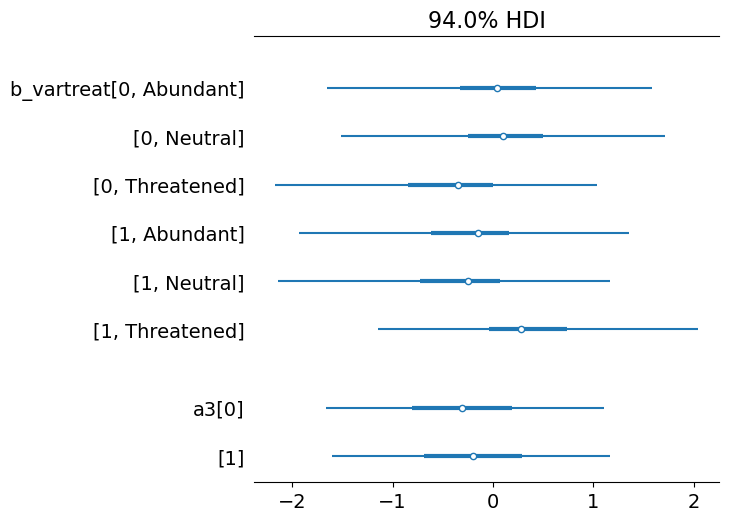

In [232]:
az.plot_forest(tracem6, 
               var_names = ['b_vartreat', 'a3'],
              combined = True)

In [212]:
# ppc: new data for c by treatment

new_c_data = {f'c{i}': np.repeat(i, len(df)) for i in range(2)}

ppcs_Ab = {}
ppcs_Neut = {}
ppcs_Threat = {}



with m6:
    for i in list(range((2))):
        pm.set_data(
            {
                "C":new_c_data[f'c{i}'],
                "T": np.repeat(0, len(df))
            }
        )
        ppcsc = pm.sample_posterior_predictive(tracem6, progressbar = False)
        ppcs_Ab[f'c{i}'] = ppcsc
        
        pm.set_data(
            {
                "S":new_c_data[f'c{i}'],
                "T": np.repeat(1, len(df))
            }
        )
        ppcsc = pm.sample_posterior_predictive(tracem6, progressbar = False)
        ppcs_Neut[f'c{i}'] = ppcsc
        
        pm.set_data(
            {
                "S":new_c_data[f'c{i}'],
                "T": np.repeat(2, len(df))
            }
        )
        ppcsc = pm.sample_posterior_predictive(tracem6, progressbar = False)
        ppcs_Threat[f'c{i}'] = ppcsc
        


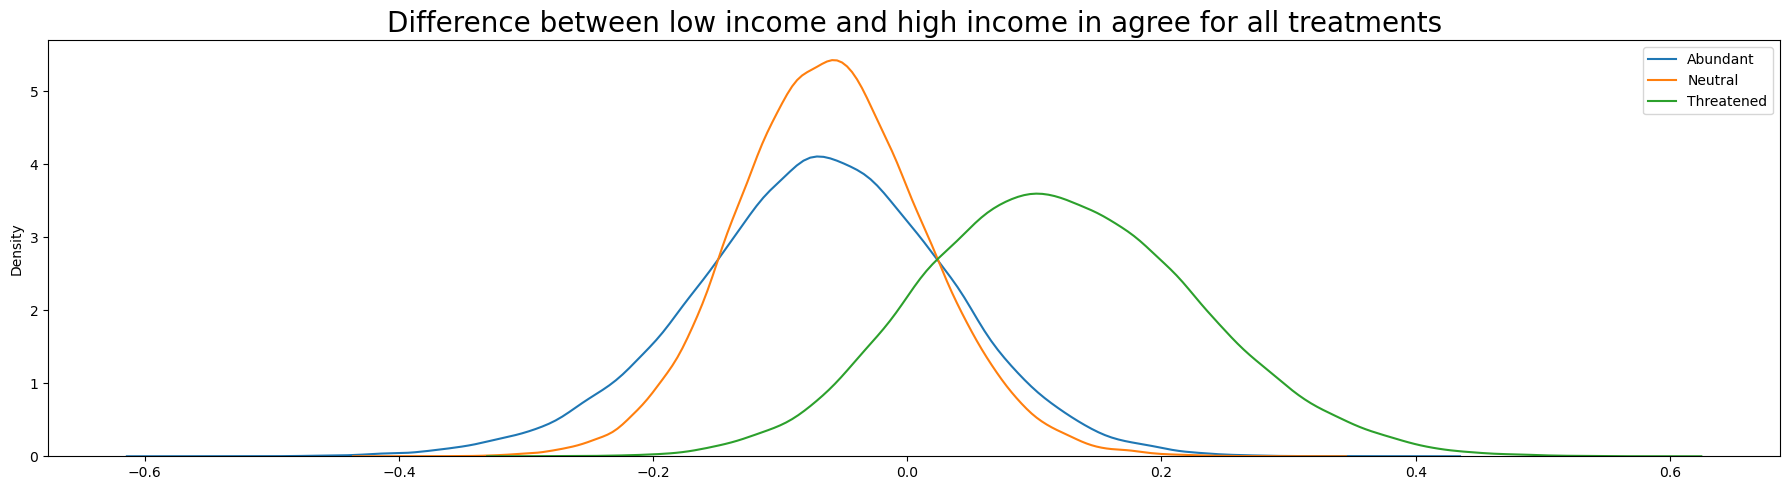

In [233]:
colors = ['orange','yellow','blue','green','red','black']

fig, ax = plt.subplots(figsize = (18,5))

for i in [ppcs_Ab, ppcs_Neut, ppcs_Threat]:
    li = az.extract(i[f'c{1}'].posterior_predictive['agree'])['agree'].values.sum(axis = 0) / len(df)
    hi = az.extract(i[f'c{0}'].posterior_predictive['agree'])['agree'].values.sum(axis = 0) / len(df)
    dif = li - hi

    sns.kdeplot(np.array(dif),ax=ax )
    
ax.set_title('Difference between low income and high income in agree for all treatments', fontsize = 20)
ax.legend(['Abundant','Neutral','Threatened'])


fig.tight_layout()

## Influence treatment vs influence species concepts

In [235]:
# create new data for T
new_t_data = {}

for i in range(3):
    new_t_data[f't{i}'] = np.repeat(i, len(df))

ppc = {}

with m6:
    for i in range(3):
        pm.set_data(
            {
                "T":new_t_data[f't{i}']
            }
        )
        ppct = pm.sample_posterior_predictive(tracem6, progressbar = False)
        ppc[f't{i}'] = ppct

Sampling: [agree]
Sampling: [agree]
Sampling: [agree]


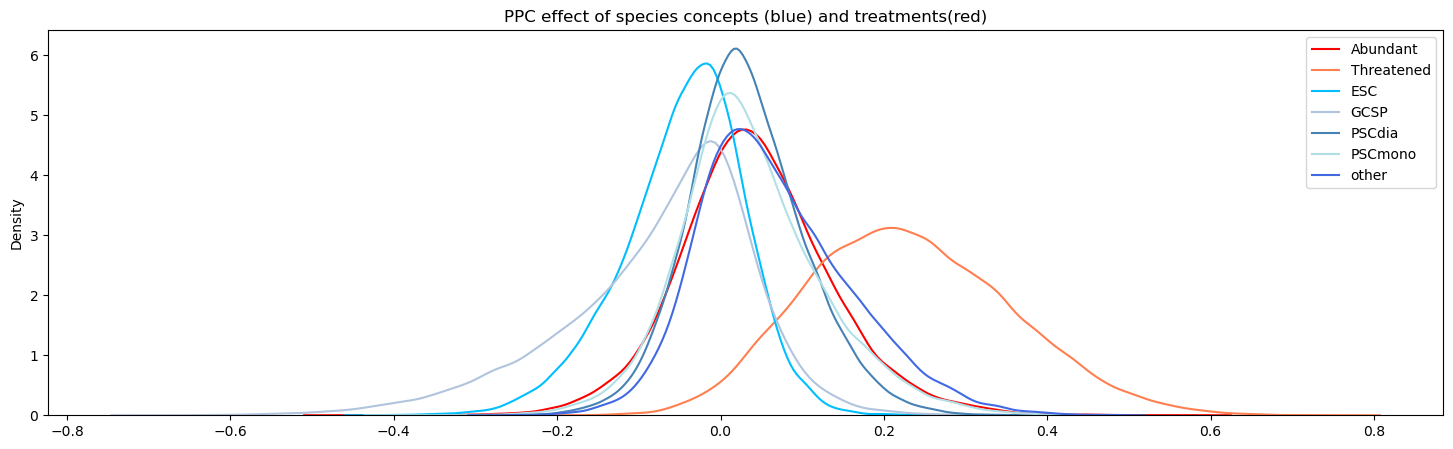

In [236]:
# compare concept effect and treatment effect

blues = [ 'blue',
 'deepskyblue',
 'lightsteelblue',
 'steelblue',
 'powderblue',
 'royalblue',
 ]
reds= ['red','orange','coral']

fig, ax = plt.subplots(figsize = (18,5))

Neut = az.extract(ppc[f't{1}'].posterior_predictive['agree'])['agree'].values.sum(axis = 0) / len(df)


for i in [0,2]:
    a = az.extract(ppc[f't{i}'].posterior_predictive['agree'])['agree'].values.sum(axis = 0) / len(df)
    sns.kdeplot(np.array(a) - Neut, color = reds[i],ax=ax)



# plot differences between BSC and the rest

BSC = az.extract(ppcs[f'sc{0}'].posterior_predictive['agree'])['agree'].values.sum(axis = 0) / len(df)


for i in range(1,6,1):
    agree_prop = az.extract(ppcs[f'sc{i}'].posterior_predictive['agree'])['agree'].values.sum(axis = 0) / len(df)
    sns.kdeplot(np.array(agree_prop - BSC), color = blues[i],ax=ax )
                    
ax.legend(['Abundant','Threatened','ESC', 'GCSP', 'PSCdia', 'PSCmono', 'other'])
ax.set_title('PPC effect of species concepts (blue) and treatments(red)')
plt.show()

## specialization

array([<Axes: title={'center': '94.0% HDI'}>], dtype=object)

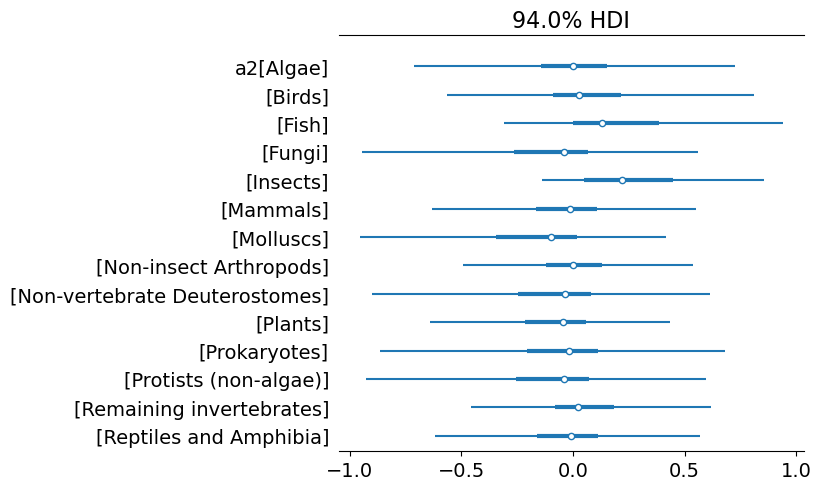

In [237]:
# coefficients

az.plot_forest(tracem6, var_names = 'a2', combined = True)

In [238]:
# create new data for Tax
new_tax_data = {}

for i in range(14):
    new_tax_data[f'tax{i}'] = np.repeat(i, len(df))

ppc_tax = {}

with m6:
    for i in range(14):
        pm.set_data(
            {
                "TA":new_tax_data[f'tax{i}']
            }
        )
        ppct = pm.sample_posterior_predictive(tracem6, progressbar = False)
        ppc_tax[f'tax{i}'] = ppct


Sampling: [agree]
Sampling: [agree]
Sampling: [agree]
Sampling: [agree]
Sampling: [agree]
Sampling: [agree]
Sampling: [agree]
Sampling: [agree]
Sampling: [agree]
Sampling: [agree]
Sampling: [agree]
Sampling: [agree]
Sampling: [agree]
Sampling: [agree]


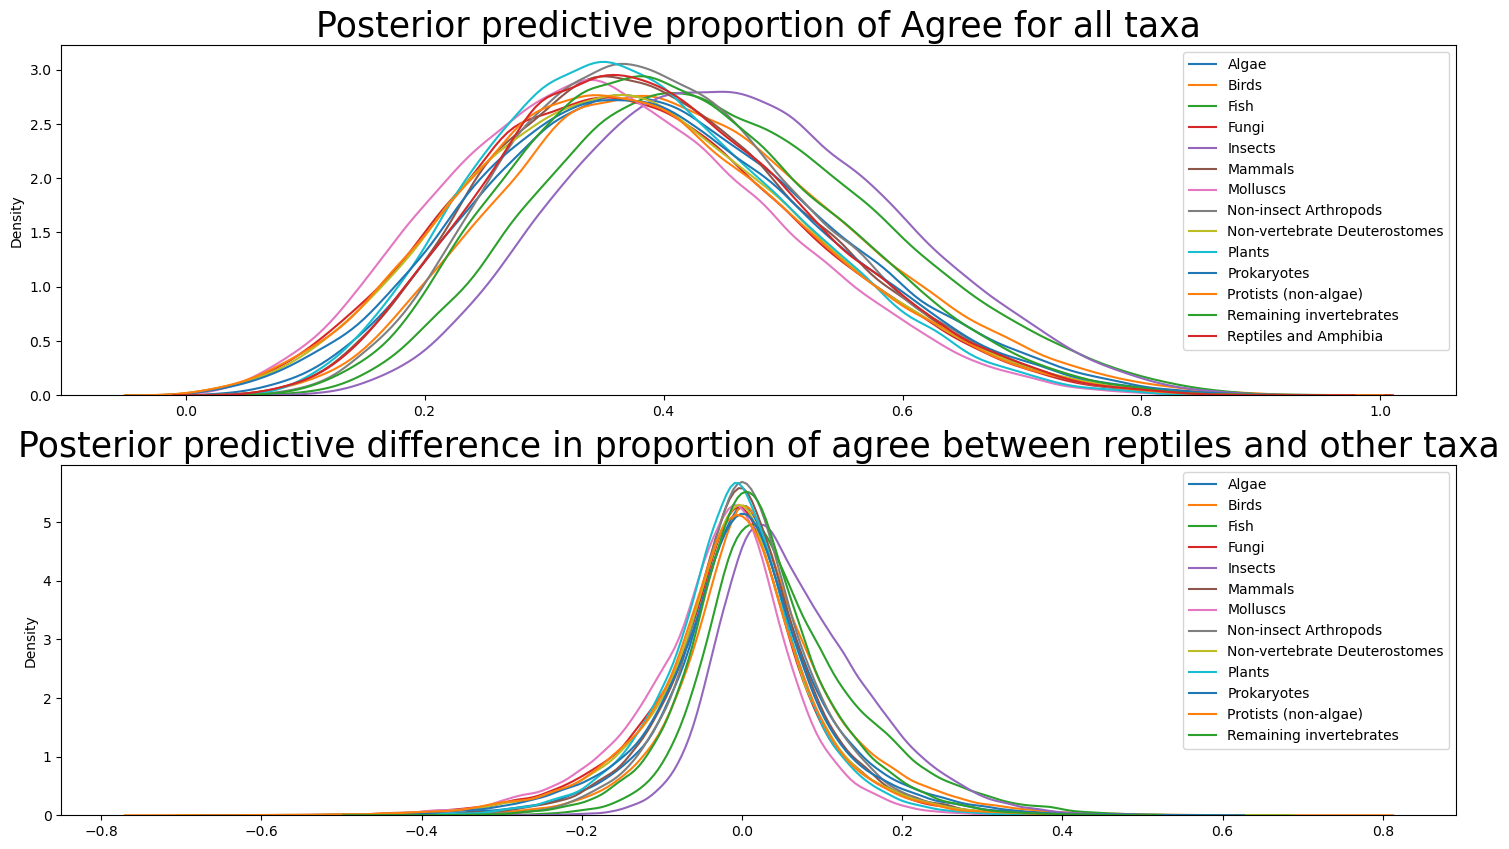

In [239]:
Reptiles = az.extract(ppc_tax[f'tax{13}'].posterior_predictive['agree'])['agree'].values.sum(axis = 0) / len(df)

fig, ax = plt.subplots(nrows = 2, figsize = (18,10))

for i in range(0,14,1):
    a = az.extract(ppc_tax[f'tax{i}'].posterior_predictive['agree'])['agree'].values.sum(axis = 0) / len(df)


    sns.kdeplot(np.array(a), ax=ax[0] )
    
ax[0].set_title('Posterior predictive proportion of Agree for all taxa', fontsize = 25)

for i in range(0,13):
    a = az.extract(ppc_tax[f'tax{i}'].posterior_predictive['agree'])['agree'].values.sum(axis = 0) / len(df)


    sns.kdeplot(np.array(a) - Reptiles, ax=ax[1] )
ax[1].set_title('Posterior predictive difference in proportion of agree between reptiles and other taxa', fontsize = 25)
ax[1].legend(list(tracem7.posterior['tax_n'].values)[:-1])
ax[0].legend(list(tracem7.posterior['tax_n'].values))

plt.show()
